Plot rocky lost and calculate some stats

In [1]:
# from BZ import *
import xarray as xr
import rioxarray as xrr
from shapely.geometry import box

import contextily as cx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import img_tiles as cimgt
import seaborn as sns

from shared import *

%matplotlib inline
%pdb off
    
print (os.getenv('CONDA_PROMPT_MODIFIER'), datetime.now())
# Rule: SetNull(CoNED < MLLW | (CoNED > ZT & ElNino > ZT)

Automatic pdb calling has been turned OFF
(SL)  2024-06-07 18:32:34.925263


# Setup

In [2]:
habit = 'rocky'
scen0   = 'med_rsl2050'
path_wd = Path(os.getenv('dataroot')) / 'Sea_Level' / 'SFEI'
use_s2  = False

## Constants
- Shouldnt have to change below here

In [3]:
path_res = path_wd / 'results'
regions = 'South Central North'.split()
scen = scen0.replace('_rsl', '')
s2_ext = '_s2' if use_s2 else ''

basemap_d = cimgt.GoogleTiles(url='https://server.arcgisonline.com/ArcGIS/rest/services/Elevation/World_Hillshade_Dark/MapServer/tile/{z}/{y}/{x}.jpg')
basemap   = cimgt.GoogleTiles(url='https://server.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}.jpg')
# basemap   = cimgt.GoogleTiles(url='https://www.google.cn/maps/vt?lyrs=s@189&gl=cn&x={x}&y={y}&z={z}'))

cxbasemap   = cx.providers.Esri.WorldImagery
cxbasemap_d = cx.providers.CartoDB.DarkMatter
cxbasemap_t = cx.providers.USGS.USTopo
            
projp = ccrs.PlateCarree()
GFS = GS  = 14 
TFS = 20 # title
XFS = YFS = 16 # x/y axis
GFS = 14 # deg marks
CFS = 18 # colorbar labels

pt_parms  = dict(verticalalignment='top', fontsize=20, color='w',
                bbox=dict(boxstyle='square,pad=0.05', facecolor='black'))

dct_proju = {'Central': ccrs.UTM(10), 'North': ccrs.UTM(10), 'South': ccrs.UTM(11)}

In [4]:
path_dems = path_wd / 'dems'
path_dems_all  = path_dems / 'all' # symlinked with everything

path_north   = path_dems / 'CA_north_coned_DEM_2020_9181'
gdf_north    = gpd.read_file(path_north / 'tileindex_CA_north_coned_DEM_2020.shp').to_crs(4326)

path_central = path_dems / 'CA_Central_CoNED_DEM_2017_8657'
gdf_central  = gpd.read_file(path_central / 'ca2017_central_coned_m8657.kmz').to_crs(4326)

path_south   = path_dems / 'CA_Southern_CoNED_DEM_2016_8658/'
gdf_south    = gpd.read_file(path_south / 'socal.kmz').to_crs(4326)

dct_gdf_bounds = {'South': gdf_south, 'Central': gdf_central, 'North': gdf_north}

In [5]:
## get the new cari; note that the shape and geojson are the same geometries despite geom_equals not saying so.
gdf_cari = gpd.read_file(path_wd  / 'CARI_polygons' / 'Cari_Rocky.GeoJSON')
gdf_cari['poly_id'] = gdf_cari.index
gdf_cari_wgs = gdf_cari.to_crs(4326)
sty_cari   = dict(facecolor='none', edgecolor='deeppink') 

## Helper Functions

In [6]:
# diff than last because of negative
def cut_polys(df_all_in, gdf_cari_in, pct_lost_min=-100, area_min=0):
    """ Input for plot_bars """
    lst_poly_area = [] # for plotting hist and excluding outliers
    polys_to_drop = []
    for poly_ix, df_poly in df_all_in.groupby('poly_ix'):
        pct_lost  = (100 * df_poly[f'{scen}_MLLW'].mean())
        cari_poly = gdf_cari_in.loc[[poly_ix]]
        cari_area = cari_poly.area.item() # m2
        if (pct_lost < pct_lost_min) | (cari_area < area_min):
            polys_to_drop.append(poly_ix)
        lst_poly_area.append(cari_area) 
        # if np.isnan(cari_area):
        #     print (poly_ix)

    n_polys = df_all_in.groupby('poly_ix').count().shape[0]
    n_pct = 100 * len(polys_to_drop) / n_polys
    print (f'Dropping {len(polys_to_drop)} of {n_polys} polygons ({n_pct:.2f}%)')
    ## good; get rid of slivers
    df_all_new = df_all_in[~df_all_in.poly_ix.isin(polys_to_drop)]
    ser_pcts_new = {}
    for reg, df_reg in df_all_new.groupby('region'):
        ser_pcts_new[reg] = 100*(df_reg[f'{scen}_MLLW'].mean())
    
    ser_pcts_new['Total'] = 100*df_all_new[f'{scen}_MLLW'].mean()
    ser_pcts_new = pd.Series(ser_pcts_new)
    return df_all_new, ser_pcts_new, lst_poly_area


# beaches only
def plot_bars(ser_pcts_in):
    ser_pcts_in.index = ser_pcts_in.index.map(lambda x: x.rstrip(f'_{k}'))
    try:
        ser_pcts_in = ser_pcts_in.loc['South Central North Total'.split()]
    except:
        print ('Couldnt sort by regions')
    fig, axes = plt.subplots(figsize=(12, 6))
    sns.barplot(data=ser_pcts_in, ax=axes, color='dimgray')
    axes.set_ylabel('Beaches Lost (%)', fontsize=YFS)
    axes.set_xlabel('Region', fontsize=XFS)
    axes.tick_params(axis='both', labelsize=XFS-4)  
    axes.bar_label(axes.containers[0], fmt="{:.1f}%".format, fontsize=XFS-4);
    axes.grid(color='k', linestyle='--', alpha=0.1)
    return fig, axes


## Get Data
- a '1' in the column means the beach was lost

In [7]:
dct_gdfs = {}
for region in regions:
    dst = path_res / f'{region}_{habit}{s2_ext}.csv'
    assert dst.exists(), f'Concatenate the {habit} with make_rocky_beach.concat_results'
    print (f'Getting {region}...')
    df = pd.read_csv(dst, index_col=0)
    dct_gdfs[region] = gpd.GeoDataFrame(df)
    print (f'Got existing {habit} at: {dst}')
    # break

Getting South...
Got existing rocky at: /scratch/tws_grace/data/Sea_Level/SFEI/results/South_rocky.csv
Getting Central...
Got existing rocky at: /scratch/tws_grace/data/Sea_Level/SFEI/results/Central_rocky.csv
Getting North...
Got existing rocky at: /scratch/tws_grace/data/Sea_Level/SFEI/results/North_rocky.csv


In [8]:
lst_dfs  = []
dct_pcts = {}
for reg, gdf in dct_gdfs.items():
    df = pd.DataFrame(gdf.drop(columns='geometry'))
    df = pd.concat([-1*df.filter(like=scen), df['poly_ix tile'.split()]], axis=1)
    df['region'] = reg
    lst_dfs.append(df)
    # compute the percentage for the region as a double check
    dct_pcts[f'{reg}_MLLW'] = 100*df[f'{scen}_MLLW'].mean()
    dct_pcts[f'{reg}_MAH'] = 100*df[f'{scen}_MAH'].mean()

df_all = pd.concat(lst_dfs)
mem_use = df_all.memory_usage(deep=True).sum() * 1e-9  # Convert bytes to GB
print(f'Memory usage of DataFrame: {mem_use:.2f} GB')

ser_pcts = pd.Series(dct_pcts)
ser_pcts['Total_MLLW'] = 100*df_all[f'{scen}_MLLW'].mean()
ser_pcts['Total_MAH'] = 100*df_all[f'{scen}_MAH'].mean()

## prepare the total percentages for plotting
df_pcts = pd.DataFrame(ser_pcts).reset_index()
df_pcts.columns = 'region pct'.split()
df_pcts[['region', 'datum']] = df_pcts['region'].str.split('_', expand=True)
df_pcts = df_pcts.pivot(index='region', columns='datum', values='pct').reset_index()#.set_index('region')
df_pcts.columns.name = ''

df_pcts_melt = df_pcts.melt(id_vars='region', var_name='datum', value_name='pct')


Memory usage of DataFrame: 5.73 GB


In [9]:
## get the pct_lost for each polygon and write to disk
ser_mllw = 100*df_all.groupby('poly_ix')[f'{scen}_MLLW'].sum() / df_all.groupby('poly_ix')[f'{scen}_MLLW'].count()
ser_mah = 100*df_all.groupby('poly_ix')[f'{scen}_MAH'].sum() / df_all.groupby('poly_ix')[f'{scen}_MAH'].count()
df_res = pd.concat([ser_mllw, ser_mah], axis=1)
df_res.columns = f'pct_chg_mllw_{scen} pct_chg_mah_{scen}'.split()

cols   = 'poly_id geometry'.split() if not use_s2 else 'geometry'
gdf_res = df_res.merge(gdf_cari.loc[df_res.index, cols], left_index=True, right_index=True)
gdf_res = gpd.GeoDataFrame(gdf_res, geometry='geometry')

dst = path_res / f'{habit}_loss_{scen}{s2_ext}.GeoJSON'
gdf_res.to_file(dst)
print (f'Wrote: {dst}')

Wrote: /scratch/tws_grace/data/Sea_Level/SFEI/results/rocky_loss_med2050.GeoJSON


# Plot the Regions and Total Hist

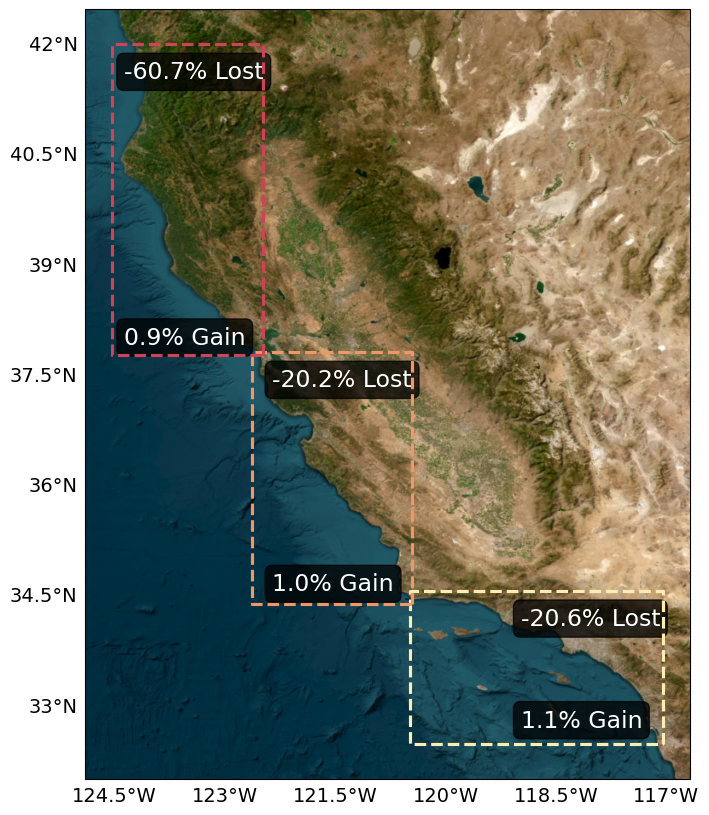

In [10]:
# dct_pct1 = {'North': 18.5, 'South': 10.9, 'Central': 12.8} # original, CARI

sty_name = dict(facecolor='black', alpha=0.75, boxstyle='round')

fig, axes = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projp})
colors = plt.cm.get_cmap('cmo.matter')
# South, Central, North
colors = [colors(0.0), colors(0.25), colors(0.5)]
xys    = (0.72, 0.20), (0.31, 0.51), (0.065, 0.91)
xys1   = (0.72, 0.068), (0.31, 0.245), (0.065, 0.565)
for i, (reg, gdf) in enumerate(dct_gdf_bounds.items()):
    gdfb = gpd.GeoSeries(box(*gdf.total_bounds), crs=gdf.crs)
    lbl_mllw  = dct_pcts[f'{reg}_MLLW']
    lbl_mah  = dct_pcts[f'{reg}_MAH']
    axes.text(*xys[i], f'{lbl_mllw:.1f}% Lost', transform=axes.transAxes, size=17, color='white', bbox=sty_name)
    axes.text(*xys1[i], f'{lbl_mah:.1f}% Gain', transform=axes.transAxes, size=17, color='white', bbox=sty_name)
    gdfb.plot(ax=axes, facecolor='none', edgecolor=colors[i], linestyle='--', linewidth=2.25, transform=projp, zorder=50)
    
gl = axes.gridlines(draw_labels=True)
try:
    bbPlot.fmt_gridlines(gl, bottom=True, size=GFS)
except:
    pass
cx.add_basemap(ax=axes, crs=gdf.crs, source=cxbasemap, attribution=False)# zoom=10)
fig.set_label(f'{habit}_Overview{s2_ext}')
# bbPlot.savefigs(path_wd, True, True, dpi=300)

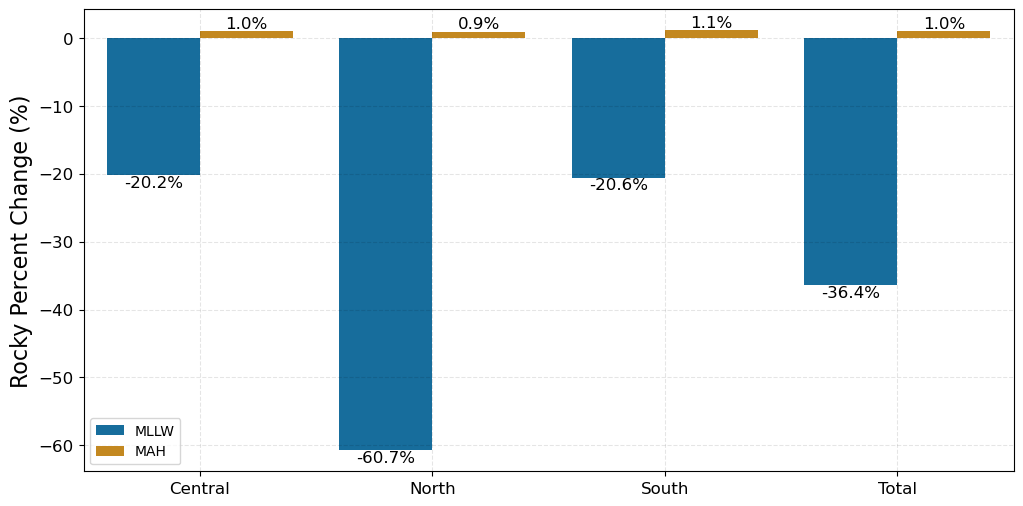

In [65]:
df_pcts_melt = df_pcts_melt.sort_values('datum', ascending=False)
fig, axes = plt.subplots(figsize=(12, 6))
bp = sns.barplot(data=df_pcts_melt, x='region', y='pct', hue='datum', palette='colorblind', ax=axes)
bp.legend().set_title('')
axes.set_ylabel('Rocky Percent Change (%)', fontsize=XFS)
axes.set_xlabel('')
axes.grid(color='k', alpha=0.1, linestyle='--')
axes.tick_params(axis='both', labelsize=XFS-4)  
axes.bar_label(axes.containers[0], fmt="{:.1f}%".format, fontsize=XFS-4);
axes.bar_label(axes.containers[1], fmt="{:.1f}%".format, fontsize=XFS-4);

## Cut by % lost

In [54]:
def prep_df_plot(df_low_in):
    df_low_reg_mllw = pd.DataFrame(df_low_in.groupby('region')[f'{scen}_MLLW'].mean().rename('MLLW')).T
    df_low_reg_mllw['Total'] = df_low_in[f'{scen}_MLLW'].mean().T
    df_low_reg_mllw.columns.name 
    
    df_low_reg_mah = pd.DataFrame(df_low_in.groupby('region')[f'{scen}_MAH'].mean().rename('MAH')).T
    df_low_reg_mah['Total'] = df_low_in[f'{scen}_MAH'].mean()
    df_low_reg_mah.columns.name  = ''
    
    df_low_out = pd.concat([df_low_reg_mllw, df_low_reg_mah]).T.rename_axis('region').reset_index()
    df_low_melt = df_low_out.melt(id_vars='region', var_name='datum', value_name='pct')
    df_low_melt['pct'] *=100
    return df_low_melt


In [ ]:
df_low, ser_pcts_low = cut_polys(df_all, gdf_cari, pct_lost_min=-80)[:2]
df_low_melt = prep_df_plot(df_low)

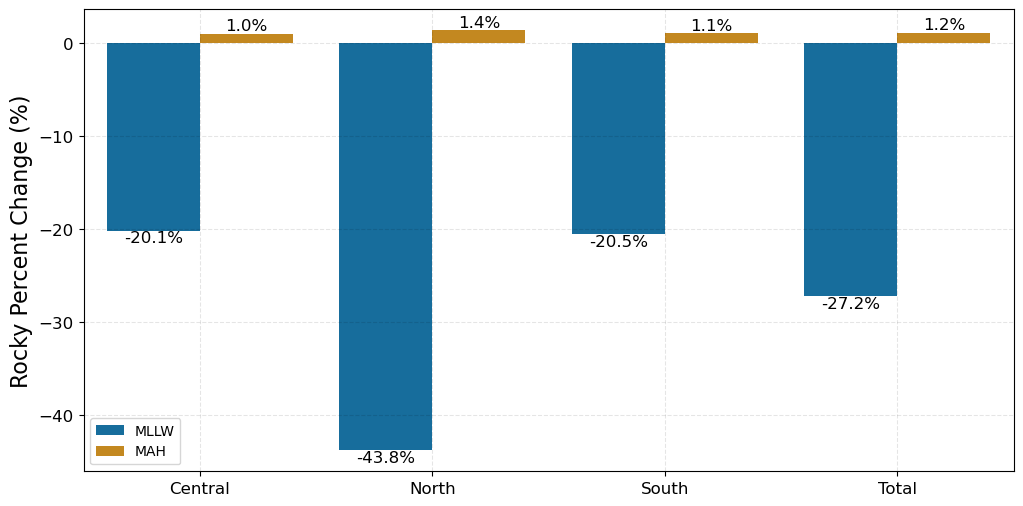

In [66]:
fig, axes = plt.subplots(figsize=(12, 6))
bp = sns.barplot(data=df_low_melt, x='region', y='pct', hue='datum', palette='colorblind', ax=axes)
bp.legend().set_title('')
axes.set_ylabel('Rocky Percent Change (%)', fontsize=XFS)
axes.set_xlabel('')
axes.grid(color='k', alpha=0.1, linestyle='--')
axes.tick_params(axis='both', labelsize=XFS-4)  
axes.bar_label(axes.containers[0], fmt="{:.1f}%".format, fontsize=XFS-4);
axes.bar_label(axes.containers[1], fmt="{:.1f}%".format, fontsize=XFS-4);

## Cut by Area

In [ ]:
df_big1, ser_pcts_big1 = cut_polys(df_all, gdf_beach, area_min=1)[:2]
plot_bars(ser_pcts_big1);

In [ ]:
df_big2, ser_pcts_big2 = cut_polys(df_all, gdf_beach, area_min=10000)[:2]
plot_bars(ser_pcts_big2);

In [ ]:
## plot the histogram to figure out where to cut; actually just use quantiles
lst_poly_area = cut_polys(df_all, gdf_beach, pct_lost_max=100, area_min=0)[2]
fig, axes = plt.subplots(figsize=(10, 4))
sns.histplot(lst_poly_area, kde=False, color='dimgray', ax=axes)
axes.set_xlim([0, 50000])
axes.set_xlabel('Area (m$^2$)')
print (f'5%: {np.nanquantile(lst_poly_area, 0.05):.2f}, 95%: {np.nanquantile(lst_poly_area, 0.95):.2f}')
print (f'5%: {np.nanmean(lst_poly_area):.2f} +/- {np.nanstd(lst_poly_area):.2f} (\n\t1*lower_bound={np.nanmean(lst_poly_area)-np.nanstd(lst_poly_area):.2f}')

# Quick Results
- Get the file of polygons IDs, percent lost, and geometry

In [186]:
src = path_res / f'{habit}_loss_{scen}{s2_ext}.GeoJSON'
gdf_lost = gpd.read_file(src)
gdf_lost.head()
gdf_lost.sort_values('pct_chg_mah_med2050', ascending=False)

,poly_ix,pct_chg_mllw_med2050,pct_chg_mah_med2050,poly_id,geometry
4969,4969,0.000000,45.454545,4969,"MULTIPOLYGON (((-322825.017 106892.772, -32282..."
4435,4435,0.000000,45.454545,4435,"MULTIPOLYGON (((210188.170 -499923.023, 210188..."
7096,7096,0.000000,45.000000,7096,"MULTIPOLYGON (((-174576.660 -164775.569, -1745..."
6798,6798,0.000000,43.243243,6798,"MULTIPOLYGON (((-172132.618 -173332.388, -1721..."
6237,6237,0.000000,42.000000,6237,"MULTIPOLYGON (((-143322.973 -216672.543, -1433..."
...,...,...,...,...,...
3601,3601,-63.636364,0.000000,3601,"MULTIPOLYGON (((-327378.781 168023.535, -32737..."
3600,3600,-71.084337,0.000000,3600,"MULTIPOLYGON (((-327463.778 167318.984, -32746..."
3599,3599,-61.764706,0.000000,3599,"MULTIPOLYGON (((-327504.108 167404.385, -32750..."
3598,3598,-72.307692,0.000000,3598,"MULTIPOLYGON (((-327676.015 167246.943, -32767..."


## Check out a high percent lost

There are 85 polygons lost more than 90%


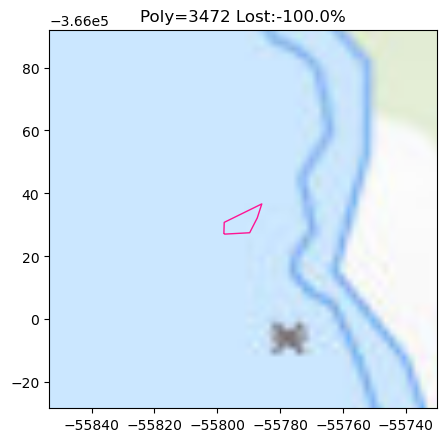

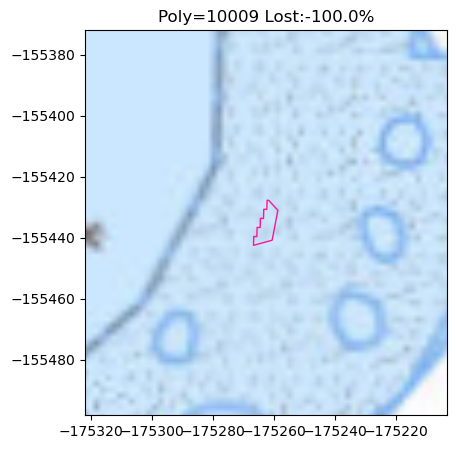

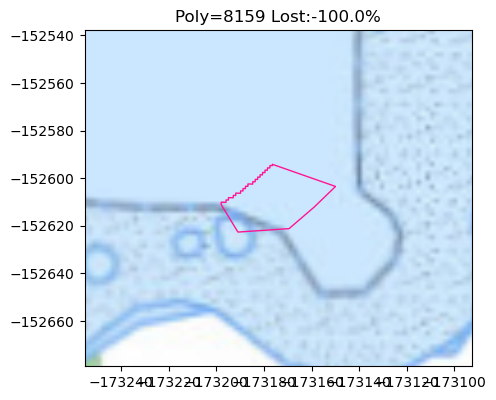

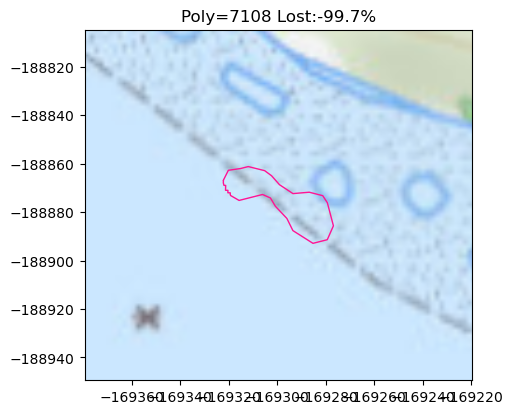

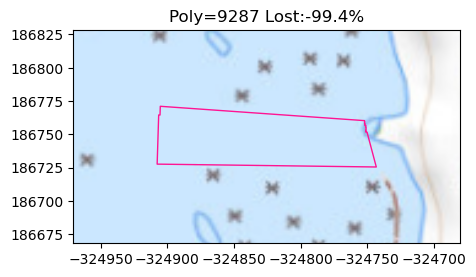

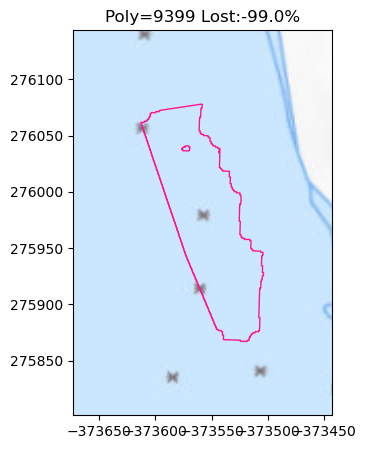

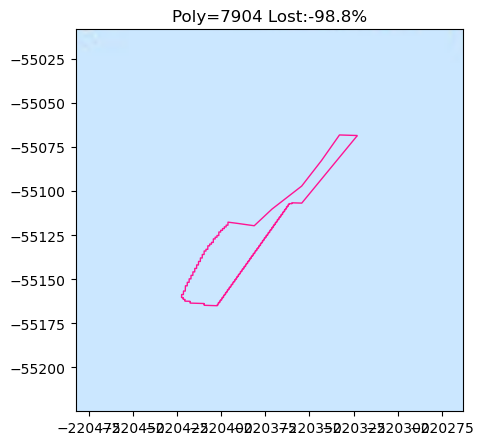

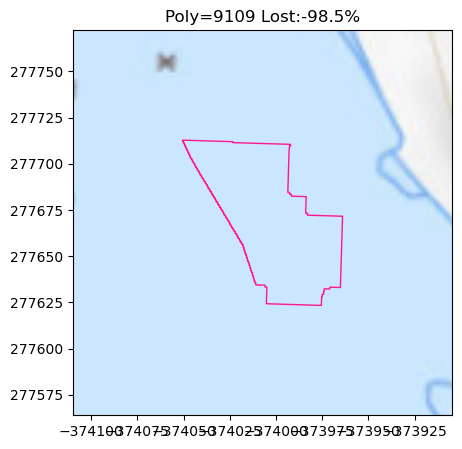

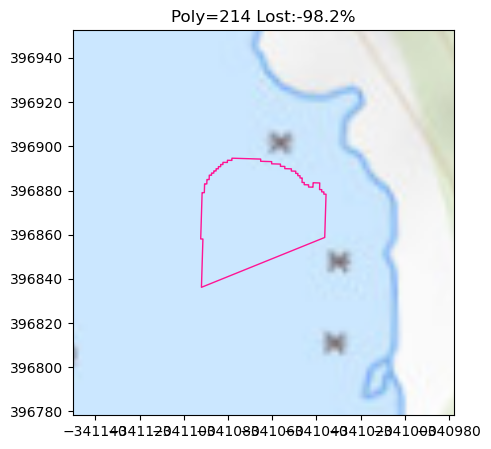

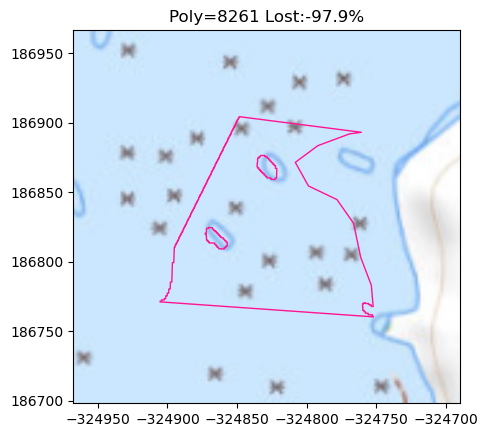

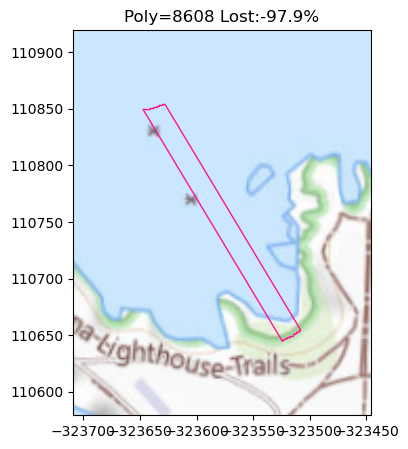

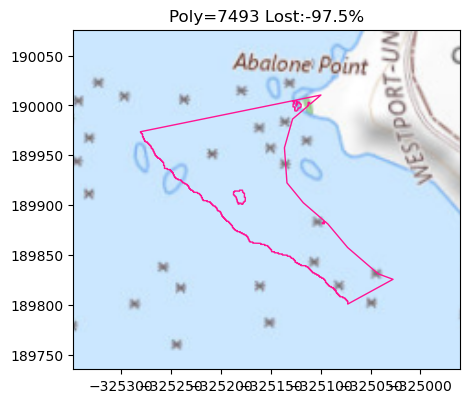

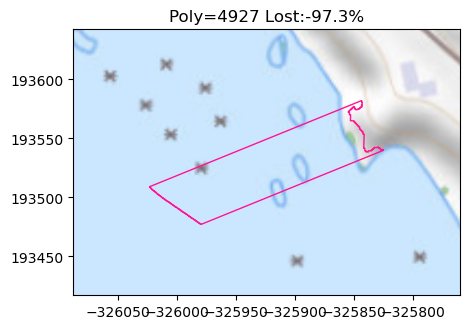

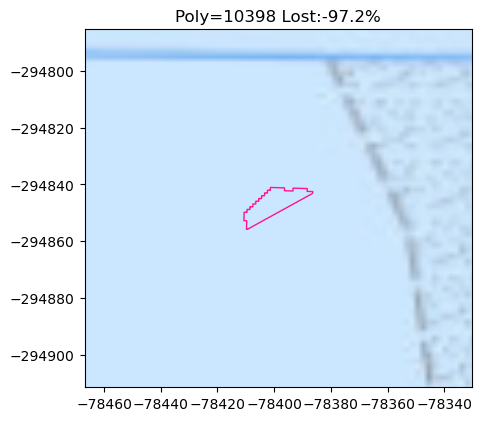

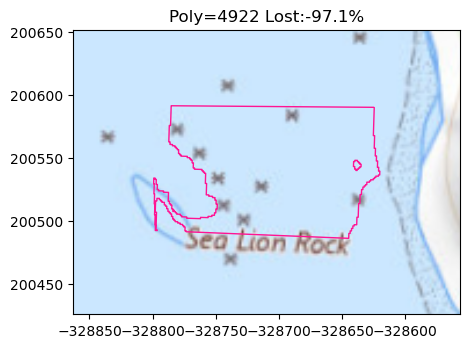

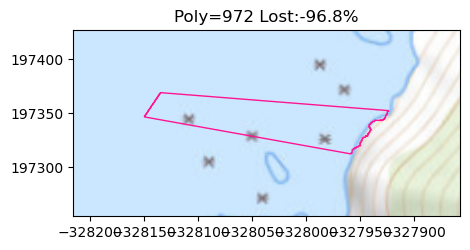

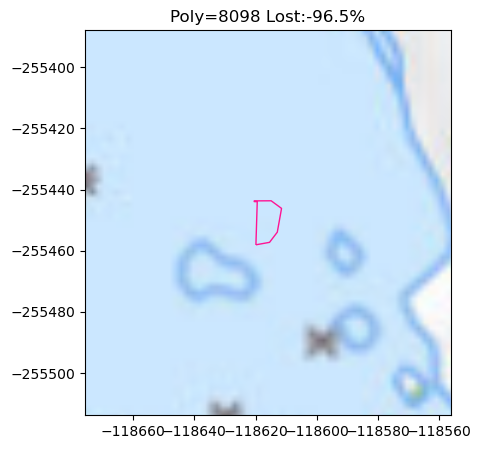

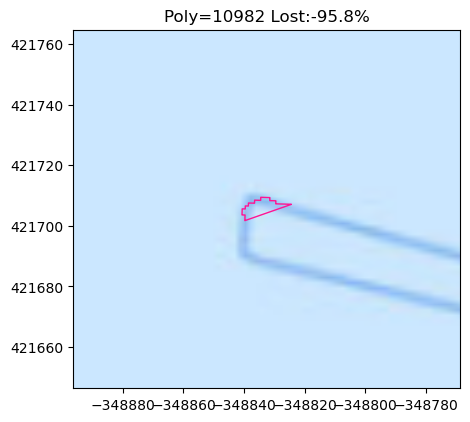

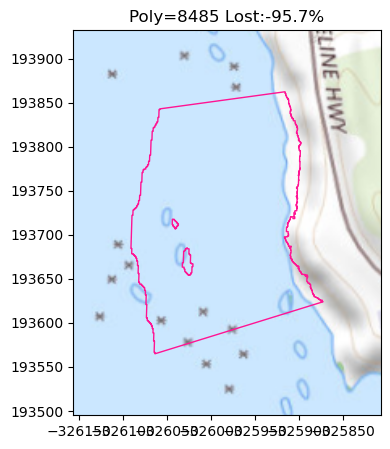

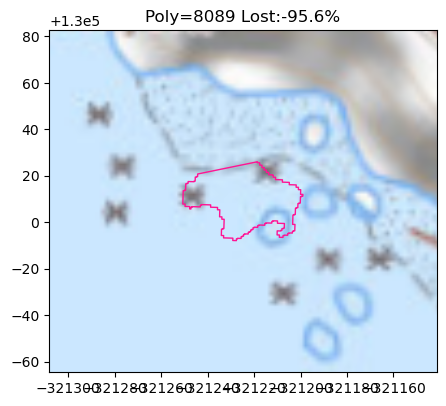

In [302]:
col = f'pct_chg_mllw_{scen}'
thresh = 90
gdf_lost_high = gdf_lost[gdf_lost[col] < -thresh].sort_values(col)
print (f'There are {gdf_lost_high.shape[0]} polygons lost more than 90%')
## plot some of them 
for i in range(20):
    fig, axes = plt.subplots(figsize=(5,5))
    gdfi = gdf_lost_high.iloc[[i]]
    gdfi.buffer(50).plot(ax=axes, alpha=0)
    gdfi.plot(ax=axes, **sty_cari)
    cx.add_basemap(ax=axes, crs=gdfi.crs, source=cxbasemap_t, attribution=False, zoom=16)
    axes.set_title(f'Poly={gdfi["poly_id"].item()} Lost:{gdfi[col].item():.1f}%')

## Check out high percent gain

In [296]:
# to find a poly ix
col = f'pct_chg_mah_{scen}'
gdf_lost.sort_values(col, ascending=False).head(20)
poly_ix = 3763

In [297]:
# load the results associated with this polygon
df_poly = df_all[df_all.poly_ix == poly_ix]
region1 = df_poly.region.unique().item()
tile1 = df_poly.tile.unique().item()

BObj = CARIRegion(region1, path_wd, use_s2)
gdf_rocky_coned = BObj.get_cari('rocky')
# gdf_enso_map = get_enso_map(BObj_north.path_enso_dems, BObj_north.epsg) # enso dem path and its bounds


In [298]:
gdf_res = gpd.read_file(BObj.path_ca_dems / f'{tile1}_{habit}.GeoJSON')
gdf_res_poly = gdf_res[gdf_res['poly_ix'] == poly_ix].copy()

In [299]:
temp1 =np.where((gdf_res_poly['MAH'] + gdf_res_poly['MAH_ENSO'])>0, 1, 0)
temp2 =np.where((gdf_res_poly[f'{scen0}_MAH'] + gdf_res_poly[f'{scen0}_MAH_ENSO'])>0, 1, 0)
# gdf_res_poly['gained_rocky'] = -100*(temp1 - temp2)
gdf_res_poly['gained_rocky'] = -(temp1 - temp2)

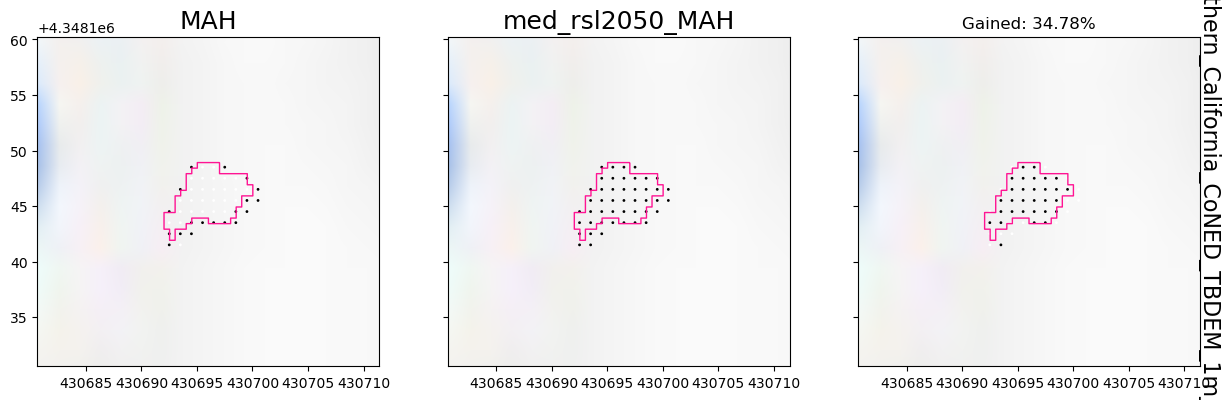

In [300]:
gdf_cari_poly = gdf_cari.loc[[poly_ix]].to_crs(gdf_res_poly.crs)
fig, axes = plt.subplots(figsize=(15, 12), ncols=3, sharey=True)
for ax, col in zip(axes, f'MAH {scen0}_MAH gained_rocky'.split()):
    gdf_cari_poly.buffer(10).plot(ax=ax, alpha=0)
    gdf_res_poly.plot(ax=ax, column=col, cmap='binary_r', markersize=1, legend=False, categorical=True)
    gdf_cari_poly.plot(ax=ax, **sty_cari)
    # add the coned bounds too
    # gser_coned_bounds.plot(ax=ax, **sty_coned)
    cx.add_basemap(ax=ax, crs=gdf_res_poly.crs, source=cxbasemap_t, attribution=False, zoom=16)
    ax.set_title(col, fontsize=TFS-2)

    # pt = point_lost if col == 'gained_rocky' else point
    # ax.legend(handles=[rect_beach, pt], loc='upper right')
    
pct_lost = 100*(gdf_res_poly['gained_rocky'].mean())
ax.set_title(f'Gained: {pct_lost:.2f}%')
ax.yaxis.set_label_position("right")
ax.set_ylabel(f'Tile: {tile}', rotation=270, labelpad=15, fontsize=YFS);